In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import Data

In [2]:
df_2020 = pd.read_csv('EtsySoldOrderItems2020.csv')
df_2021 = pd.read_csv('EtsySoldOrderItems2021.csv')
df_2022 = pd.read_csv('EtsySoldOrderItems2022.csv')

# Data Cleaning

In [3]:
# combine all years to one table
df = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)

In [4]:
# drop unnecessary columns
df = df.drop(['Coupon Details', 'Currency', 'Date Paid', 'Order Type', 'Listings Type', 
              'Payment Type', 'InPerson Discount', 'InPerson Location', 'VAT Paid by Buyer', 'SKU'], axis = 1)
df.head()

,Sale Date,Item Name,Buyer ID,Quantity,Price,Coupon Code,Discount Amount,Shipping Discount,Order Shipping,Order Sales Tax,Item Total,Transaction ID,Listing ID,Date Shipped,Ship City,Ship State,Ship Country,Order ID,Variations
0,12/29/2020,A&MT Vintage Christmas Holiday Floral Embroide...,ipe60610,1,15.99,NaN,0.0,0.0,6.0,0.0,15.99,2237739574,861751257,12/29/2020,Chicago,IL,United States,1906453649,Shape:Square
1,12/29/2020,A&MT Embroidered and Floral Cutwork Design Lin...,kotnowsk,2,14.99,NaN,0.0,6.0,0.0,0.0,29.98,2247365609,811805157,12/29/2020,Simi Valley,CA,United States,1906449035,Shape:Square
2,12/29/2020,A&MT Blue Floral Cross Stitch with Cutwork Emb...,kotnowsk,1,14.99,NaN,0.0,0.0,0.0,0.0,14.99,2247365607,838871707,12/29/2020,Simi Valley,CA,United States,1906449035,Shape:Square
3,12/29/2020,A&MT 100% Cotton Handmade Crochet Lace with Em...,hez92109,1,68.99,NaN,0.0,6.0,0.0,0.0,68.99,2247299651,800096624,12/29/2020,SAN DIEGO,CA,United States,1906402877,"Size:68x86 OB inches,Color:Beige"
4,12/28/2020,A&MT Handmade Battenberg Lace Rectangular Tiss...,IRANDA P,1,8.99,NaN,0.0,6.0,0.0,0.0,8.99,2246478261,800000796,12/28/2020,REGO PARK,NY,United States,1905791557,NaN


In [5]:
# check for null
df.isnull().sum()

Sale Date               0
Item Name               0
Buyer ID                0
Quantity                0
Price                   0
Coupon Code          3439
Discount Amount         0
Shipping Discount       0
Order Shipping          0
Order Sales Tax         0
Item Total              0
Transaction ID          0
Listing ID              0
Date Shipped            3
Ship City               0
Ship State              1
Ship Country            0
Order ID                0
Variations            719
dtype: int64

In [6]:
# check data types
df.dtypes

Sale Date             object
Item Name             object
Buyer ID              object
Quantity               int64
Price                float64
Coupon Code           object
Discount Amount      float64
Shipping Discount    float64
Order Shipping       float64
Order Sales Tax      float64
Item Total           float64
Transaction ID         int64
Listing ID             int64
Date Shipped          object
Ship City             object
Ship State            object
Ship Country          object
Order ID               int64
Variations            object
dtype: object

In [7]:
# convert sale date to datetime
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

In [8]:
# add month and year columns
df['Month'] = df['Sale Date'].dt.month
df['Year'] = df['Sale Date'].dt.year

In [9]:
# summary stats
df[['Quantity', 'Price', 'Item Total']].describe()

,Quantity,Price,Item Total
count,3670.000000,3670.000000,3670.000000
mean,1.375477,28.148638,32.700150
std,1.343102,33.108121,37.952094
min,1.000000,1.250000,1.250000
25%,1.000000,12.990000,14.990000
50%,1.000000,15.990000,18.990000
75%,1.000000,24.990000,29.980000
max,50.000000,196.990000,499.500000


In [10]:
# separate data for important product categories
df_tablecloth = df[df['Item Name'].str.contains('Tablecloth')]
df_tablerunner = df[df['Item Name'].str.contains('Runner')]
df_tabletopper = df[df['Item Name'].str.contains('Topper')]
df_placemats = df[df['Item Name'].str.contains('Placemats')]
df_pillow = df[df['Item Name'].str.contains('Pillow')]
df_Christmas = df[df['Item Name'].str.contains('Christmas')]

# Exploratory Data Analysis

## Quantity

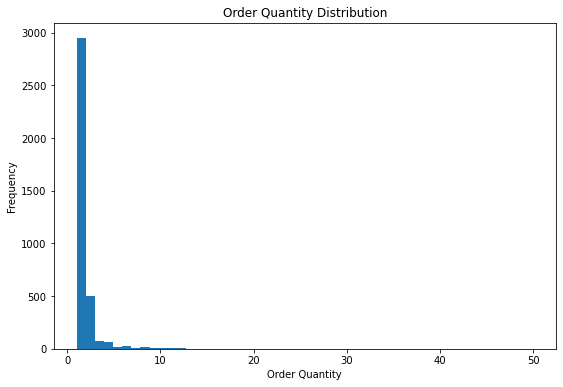

In [11]:
df['Quantity'].plot(kind = 'hist', bins = 50, figsize = (9, 6), title = 'Order Quantity Distribution', 
                 grid = False).set_xlabel('Order Quantity');

## Price

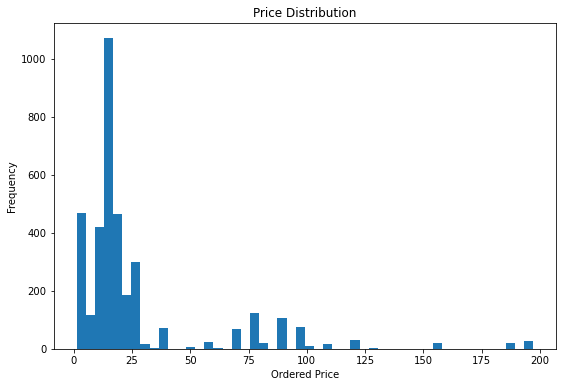

In [12]:
df['Price'].plot(kind = 'hist', bins = 50, figsize = (9, 6), title = 'Price Distribution', 
                 grid = False).set_xlabel('Ordered Price');

## Sales

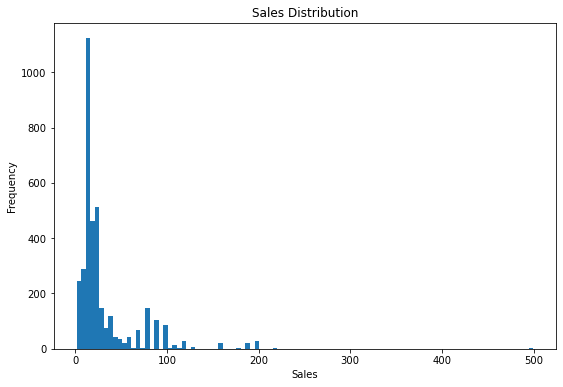

In [13]:
df['Item Total'].plot(kind = 'hist', bins = 100, figsize = (9, 6), title = 'Sales Distribution', 
                      grid = False).set_xlabel('Sales');

# KPIs

## Monthly Revenue

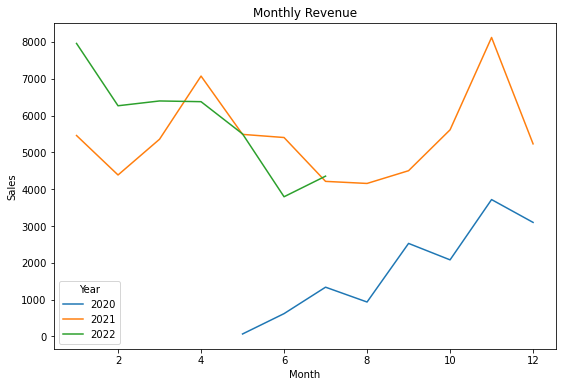

In [14]:
monthly_rev = df.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
# monthly_rev
monthly_rev.pivot('Month', 'Year', 'Item Total').plot(figsize = (9, 6), title = 'Monthly Revenue', 
                                                     xlabel = 'Month', ylabel = 'Sales');

### Monthly Revenue by Category

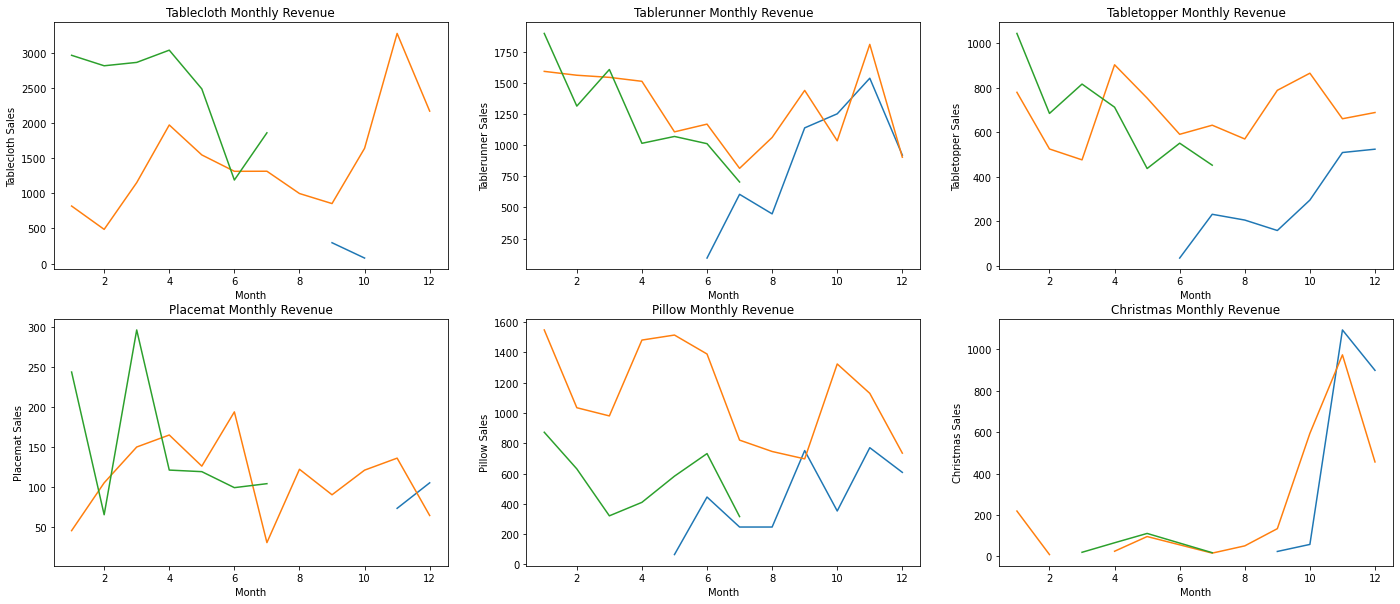

In [15]:
fig, ax = plt.subplots(2, 3, figsize = (24, 10))

monthly_rev_tb = df_tablecloth.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[0, 0].plot(monthly_rev_tb.pivot('Month', 'Year', 'Item Total'))
ax[0, 0].title.set_text('Tablecloth Monthly Revenue')
ax[0, 0].set_xlabel('Month');
ax[0, 0].set_ylabel('Tablecloth Sales');

monthly_rev_tr = df_tablerunner.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[0, 1].plot(monthly_rev_tr.pivot('Month', 'Year', 'Item Total'))
ax[0, 1].title.set_text('Tablerunner Monthly Revenue')
ax[0, 1].set_xlabel('Month');
ax[0, 1].set_ylabel('Tablerunner Sales');

monthly_rev_tp = df_tabletopper.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[0, 2].plot(monthly_rev_tp.pivot('Month', 'Year', 'Item Total'))
ax[0, 2].title.set_text('Tabletopper Monthly Revenue')
ax[0, 2].set_xlabel('Month');
ax[0, 2].set_ylabel('Tabletopper Sales');

monthly_rev_pm = df_placemats.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[1, 0].plot(monthly_rev_pm.pivot('Month', 'Year', 'Item Total'))
ax[1, 0].title.set_text('Placemat Monthly Revenue')
ax[1, 0].set_xlabel('Month');
ax[1, 0].set_ylabel('Placemat Sales');

monthly_rev_pw = df_pillow.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[1, 1].plot(monthly_rev_pw.pivot('Month', 'Year', 'Item Total'))
ax[1, 1].title.set_text('Pillow Monthly Revenue')
ax[1, 1].set_xlabel('Month');
ax[1, 1].set_ylabel('Pillow Sales');

monthly_rev_xmas = df_Christmas.groupby(['Year', 'Month'])['Item Total'].sum().reset_index()
ax[1, 2].plot(monthly_rev_xmas.pivot('Month', 'Year', 'Item Total'))
ax[1, 2].title.set_text('Christmas Monthly Revenue')
ax[1, 2].set_xlabel('Month');
ax[1, 2].set_ylabel('Christmas Sales');

## Monthly Revenue Growth Rate

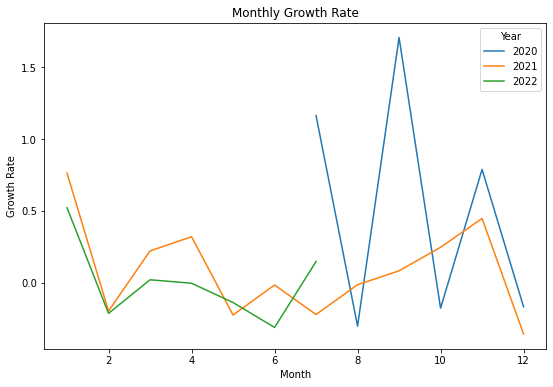

In [16]:
monthly_rev['Growth Rate'] = monthly_rev['Item Total'].pct_change()

# drop beginning two month's growth rate because shop opened end of the month
monthly_rev = monthly_rev.drop([0, 1])

# monthly_rev
monthly_rev.pivot('Month', 'Year', 'Growth Rate').plot(figsize = (9, 6), title = 'Monthly Growth Rate', 
                                                     xlabel = 'Month', ylabel = 'Growth Rate');

### Monthly Revenue Growth Rate by Category

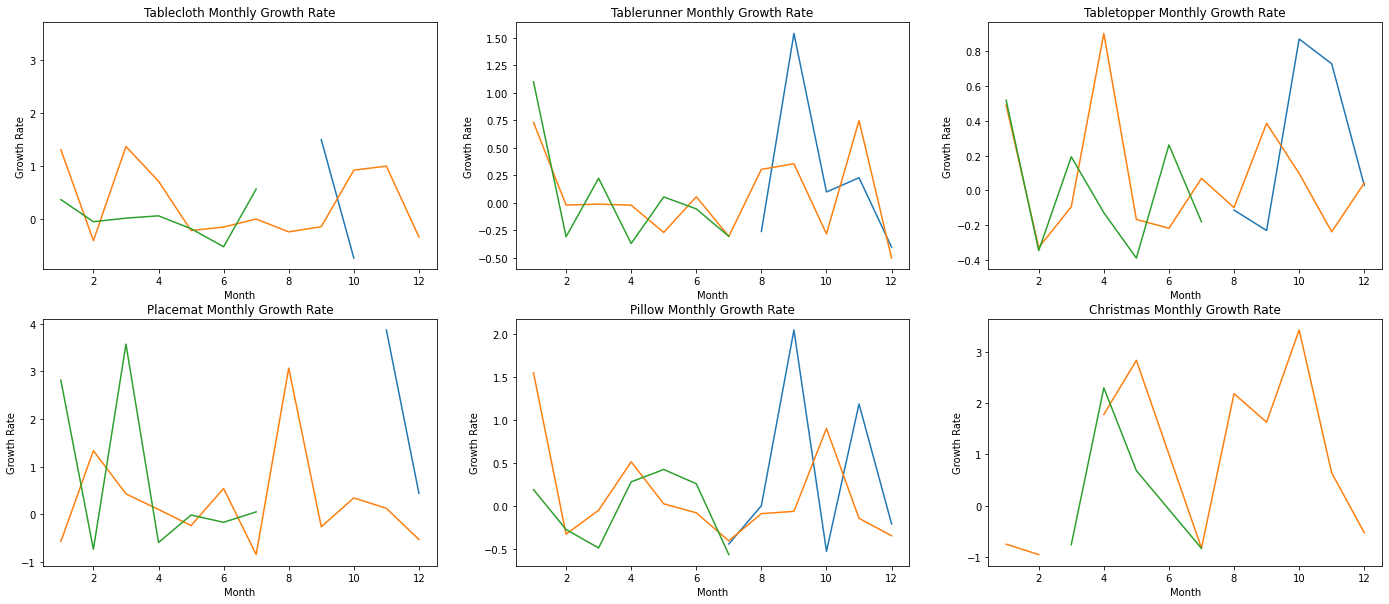

In [17]:
fig, ax = plt.subplots(2, 3, figsize = (24, 10))

monthly_rev_tb['Growth Rate'] = monthly_rev_tb['Item Total'].pct_change()
ax[0, 0].plot(monthly_rev_tb.pivot('Month', 'Year', 'Growth Rate'))
ax[0, 0].title.set_text('Tablecloth Monthly Growth Rate')
ax[0, 0].set_xlabel('Month');
ax[0, 0].set_ylabel('Growth Rate');

monthly_rev_tr['Growth Rate'] = monthly_rev_tr['Item Total'].pct_change()
monthly_rev_tr = monthly_rev_tr.drop([0, 1])
ax[0, 1].plot(monthly_rev_tr.pivot('Month', 'Year', 'Growth Rate'))
ax[0, 1].title.set_text('Tablerunner Monthly Growth Rate')
ax[0, 1].set_xlabel('Month');
ax[0, 1].set_ylabel('Growth Rate');

monthly_rev_tp['Growth Rate'] = monthly_rev_tp['Item Total'].pct_change()
monthly_rev_tp = monthly_rev_tp.drop([0, 1])
ax[0, 2].plot(monthly_rev_tp.pivot('Month', 'Year', 'Growth Rate'))
ax[0, 2].title.set_text('Tabletopper Monthly Growth Rate')
ax[0, 2].set_xlabel('Month');
ax[0, 2].set_ylabel('Growth Rate');

monthly_rev_pm['Growth Rate'] = monthly_rev_pm['Item Total'].pct_change()
ax[1, 0].plot(monthly_rev_pm.pivot('Month', 'Year', 'Growth Rate'))
ax[1, 0].title.set_text('Placemat Monthly Growth Rate')
ax[1, 0].set_xlabel('Month');
ax[1, 0].set_ylabel('Growth Rate');

monthly_rev_pw['Growth Rate'] = monthly_rev_pw['Item Total'].pct_change()
monthly_rev_pw = monthly_rev_pw.drop([0, 1])
ax[1, 1].plot(monthly_rev_pw.pivot('Month', 'Year', 'Growth Rate'))
ax[1, 1].title.set_text('Pillow Monthly Growth Rate')
ax[1, 1].set_xlabel('Month');
ax[1, 1].set_ylabel('Growth Rate');

monthly_rev_xmas['Growth Rate'] = monthly_rev_xmas['Item Total'].pct_change()
monthly_rev_xmas = monthly_rev_xmas.drop([0, 2])
ax[1, 2].plot(monthly_rev_xmas.pivot('Month', 'Year', 'Growth Rate'))
ax[1, 2].title.set_text('Christmas Monthly Growth Rate')
ax[1, 2].set_xlabel('Month');
ax[1, 2].set_ylabel('Growth Rate');

## Top 10 States by Sales

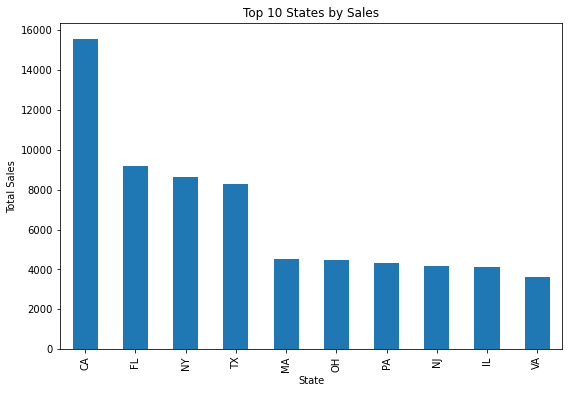

In [18]:
top_states = df.groupby(['Ship State'])['Item Total'].sum().sort_values(ascending = False).head(10)
top_states.plot(kind = 'bar', figsize = (9, 6), title = 'Top 10 States by Sales', xlabel = 'State', 
                ylabel = 'Total Sales');

## Monthly Active Customers

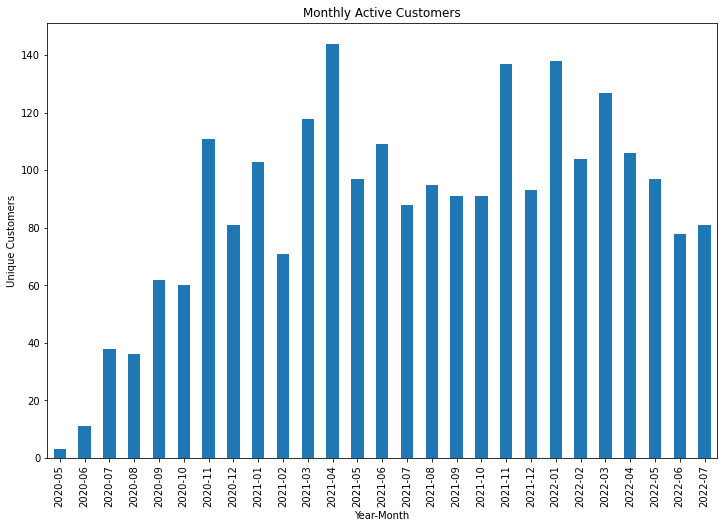

In [19]:
monthly_active = df.groupby(df['Sale Date'].dt.to_period('M'))['Buyer ID'].nunique()
# monthly_active
monthly_active.plot(kind = 'bar', figsize = (12, 8), title = 'Monthly Active Customers', xlabel = 'Year-Month', 
                ylabel = 'Unique Customers');

## Average Order Value

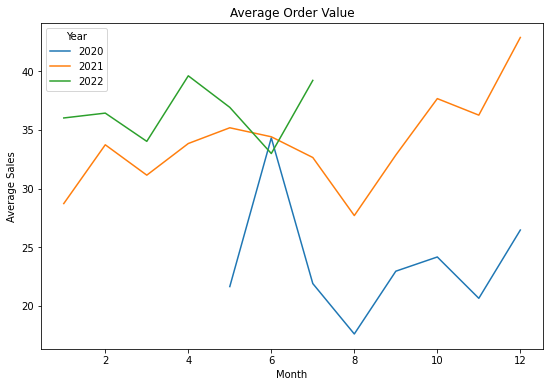

In [20]:
aov = df.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
# aov
aov.pivot('Month', 'Year', 'Item Total').plot(figsize = (9, 6), title = 'Average Order Value', 
                                                     xlabel = 'Month', ylabel = 'Average Sales');

### Average Order Value by Category

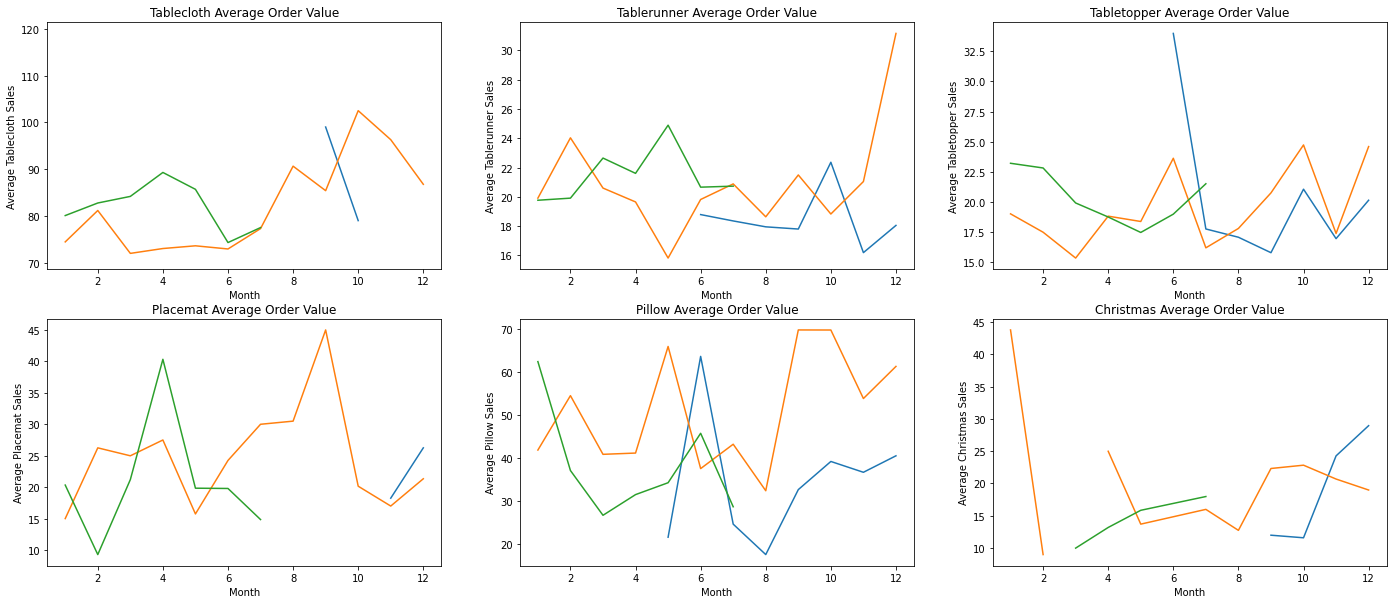

In [21]:
fig, ax = plt.subplots(2, 3, figsize = (24, 10))

monthly_aov_tb = df_tablecloth.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[0, 0].plot(monthly_aov_tb.pivot('Month', 'Year', 'Item Total'))
ax[0, 0].title.set_text('Tablecloth Average Order Value')
ax[0, 0].set_xlabel('Month');
ax[0, 0].set_ylabel('Average Tablecloth Sales');

monthly_aov_tr = df_tablerunner.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[0, 1].plot(monthly_aov_tr.pivot('Month', 'Year', 'Item Total'))
ax[0, 1].title.set_text('Tablerunner Average Order Value')
ax[0, 1].set_xlabel('Month');
ax[0, 1].set_ylabel('Average Tablerunner Sales');

monthly_aov_tp = df_tabletopper.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[0, 2].plot(monthly_aov_tp.pivot('Month', 'Year', 'Item Total'))
ax[0, 2].title.set_text('Tabletopper Average Order Value')
ax[0, 2].set_xlabel('Month');
ax[0, 2].set_ylabel('Average Tabletopper Sales');

monthly_aov_pm = df_placemats.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[1, 0].plot(monthly_aov_pm.pivot('Month', 'Year', 'Item Total'))
ax[1, 0].title.set_text('Placemat Average Order Value')
ax[1, 0].set_xlabel('Month');
ax[1, 0].set_ylabel('Average Placemat Sales');

monthly_aov_pw = df_pillow.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[1, 1].plot(monthly_aov_pw.pivot('Month', 'Year', 'Item Total'))
ax[1, 1].title.set_text('Pillow Average Order Value')
ax[1, 1].set_xlabel('Month');
ax[1, 1].set_ylabel('Average Pillow Sales');

monthly_aov_xmas = df_Christmas.groupby(['Year', 'Month'])['Item Total'].mean().reset_index()
ax[1, 2].plot(monthly_aov_xmas.pivot('Month', 'Year', 'Item Total'))
ax[1, 2].title.set_text('Christmas Average Order Value')
ax[1, 2].set_xlabel('Month');
ax[1, 2].set_ylabel('Average Christmas Sales');

## New Customers Growth Rate

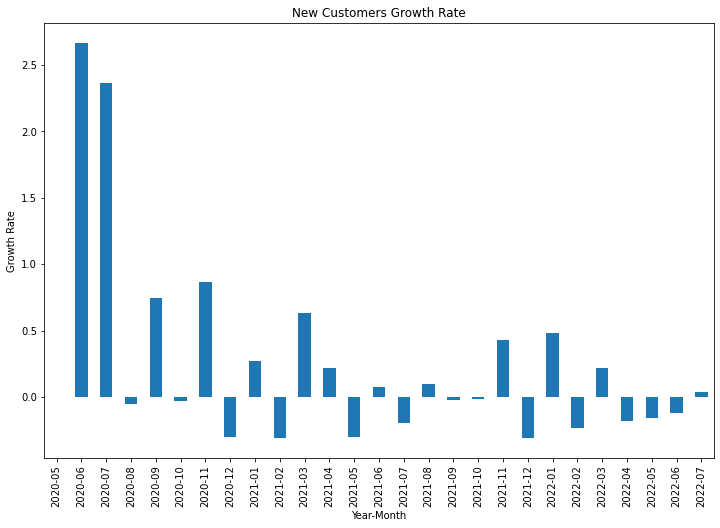

In [22]:
first_purchase = df.groupby('Buyer ID')['Sale Date'].min().reset_index()
first_purchase['Sale Date'] = first_purchase['Sale Date'].dt.to_period('M')
# first_purchase
first_purchase.groupby(['Sale Date'])['Buyer ID'].nunique().pct_change().plot(kind = 'bar', 
                        figsize = (12, 8), title = 'New Customers Growth Rate', xlabel = 'Year-Month', 
                        ylabel = 'Growth Rate');

# Customer Segmentation

## RFM

### Calculate RFM

In [23]:
# add a day to latest date to calculate recency
df['Sale Date'] = [d.date() for d in df['Sale Date']]
last_date = df['Sale Date'].max() + dt.timedelta(days = 1)

In [24]:
rfm = df.groupby(['Buyer ID']).agg({'Sale Date': lambda x: (last_date - x.max()).days, 
                                       'Transaction ID': 'count', 'Item Total':'sum'})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Buyer ID,,,
Andrews,407,2,25.98
Bell191,201,2,41.98
Boggs41,74,2,66.97
Carter3,363,3,80.94
Danna23,609,1,186.99


### Dividing Customers into 4 Segments

In [25]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, range(4, 0, -1))

# rank frequency b/c too many duplicate values to put into quartiles
# rank workaround will cause same values into to different categories
rfm['F'] = rfm['Frequency'].transform(lambda x: pd.qcut(x.rank(method = 'first'), 
                                                        4, range(1, 5)))
rfm['M'] = pd.qcut(rfm['Monetary'], 4, range(1, 5))
rfm.head()

,Recency,Frequency,Monetary,R,F,M
Buyer ID,,,,,,
Andrews,407,2,25.98,2,3,2
Bell191,201,2,41.98,3,3,3
Boggs41,74,2,66.97,4,3,3
Carter3,363,3,80.94,2,4,4
Danna23,609,1,186.99,1,1,4


### Calculate RFM Score

In [26]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str) 
rfm['Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,Segment,Score
Buyer ID,,,,,,,,
Andrews,407,2,25.98,2,3,2,232,7
Bell191,201,2,41.98,3,3,3,333,9
Boggs41,74,2,66.97,4,3,3,433,10
Carter3,363,3,80.94,2,4,4,244,10
Danna23,609,1,186.99,1,1,4,114,6


### RFM Levels

In [27]:
def rfm_level(df):
    if df['Score'] >= 10:
        return 'High Value'
    elif (df['Score'] < 10) & (df['Score'] >= 6):
        return 'Mid Value'
    else:
        return 'Low Value'
    
rfm['Level'] = rfm.apply(rfm_level, axis = 1)
rfm.head(15)

,Recency,Frequency,Monetary,R,F,M,Segment,Score,Level
Buyer ID,,,,,,,,,
Andrews,407,2,25.98,2,3,2,232,7,Mid Value
Bell191,201,2,41.98,3,3,3,333,9,Mid Value
Boggs41,74,2,66.97,4,3,3,433,10,High Value
Carter3,363,3,80.94,2,4,4,244,10,High Value
Danna23,609,1,186.99,1,1,4,114,6,Mid Value
De Garc,466,10,173.90,2,4,4,244,10,High Value
ESTRADA,310,1,98.99,3,1,4,314,8,Mid Value
Ebdon47,58,2,91.96,4,3,4,434,11,High Value
Evans32,74,1,196.99,4,1,4,414,9,Mid Value


In [28]:
rfm_level = rfm.groupby(['Level']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean','count']}).round(1)
rfm_level

Recency Frequency Monetary      
              mean      mean     mean count
Level                                      
High Value   184.6       3.0    109.4   433
Low Value    547.5       1.0     17.4   465
Mid Value    338.6       1.4     48.9  1320

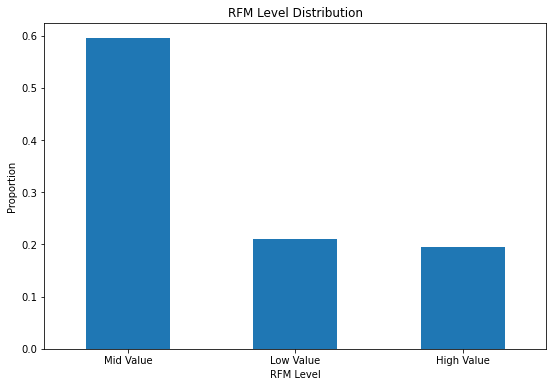

In [29]:
rfm['Level'].value_counts(normalize = True).plot(kind ='bar', figsize = (9, 6), rot = 0, title = 'RFM Level Distribution',
                                                 xlabel = 'RFM Level', ylabel = 'Proportion');

In [30]:
print("Best Customers: ", len(rfm[rfm['Segment'] == '444']))
print('Loyal Customers: ',len(rfm[rfm['F'] == 4]))
print("Big Spenders: ",len(rfm[rfm['M'] == 4]))
print('Almost Lost: ', len(rfm[rfm['Segment'] == '321']))
print('Lost Customers: ',len(rfm[rfm['R'] == 1]))
print('Lost Low Spenders: ',len(rfm[rfm['Segment'] == '111']))

Best Customers:  55
Loyal Customers:  555
Big Spenders:  551
Almost Lost:  40
Lost Customers:  554
Lost Low Spenders:  54


## KMeans

### Normalize Data

In [31]:
data = rfm[['Recency', 'Frequency', 'Monetary']]
data.head()

,Recency,Frequency,Monetary
Buyer ID,,,
Andrews,407,2,25.98
Bell191,201,2,41.98
Boggs41,74,2,66.97
Carter3,363,3,80.94
Danna23,609,1,186.99


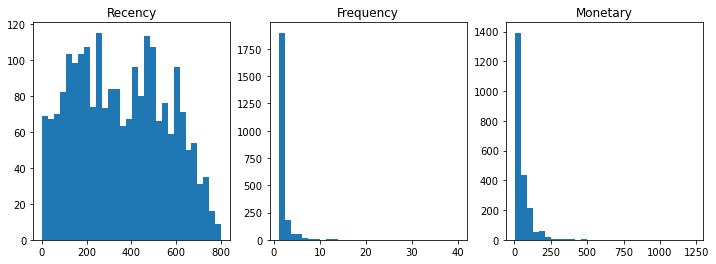

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].hist(data['Recency'], bins = 30);
ax[0].title.set_text('Recency')

ax[1].hist(data['Frequency'], bins = 30);
ax[1].title.set_text('Frequency')

ax[2].hist(data['Monetary'], bins = 30);
ax[2].title.set_text('Monetary')

In [33]:
log_data = np.log(data)
log_data.head()

,Recency,Frequency,Monetary
Buyer ID,,,
Andrews,6.008813,0.693147,3.257327
Bell191,5.303305,0.693147,3.737193
Boggs41,4.304065,0.693147,4.204245
Carter3,5.894403,1.098612,4.393708
Danna23,6.411818,0.000000,5.231055


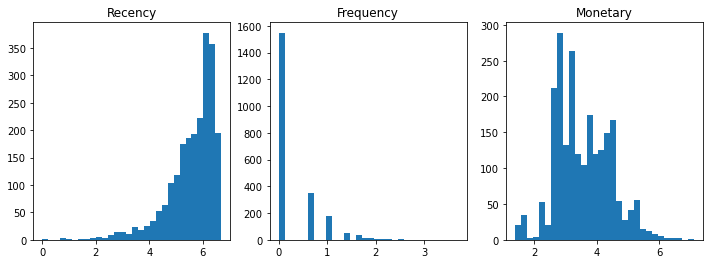

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].hist(log_data['Recency'], bins = 30);
ax[0].title.set_text('Recency')

ax[1].hist(log_data['Frequency'], bins = 30);
ax[1].title.set_text('Frequency')

ax[2].hist(log_data['Monetary'], bins = 30);
ax[2].title.set_text('Monetary')

### Standardize Variables

In [35]:
scaler = StandardScaler()
scaler.fit(log_data)
normal_data = scaler.transform(log_data)
df_normal = pd.DataFrame(normal_data, index = log_data.index, columns = log_data.columns)
df_normal.describe().round(2)

,Recency,Frequency,Monetary
count,2218.00,2218.00,2218.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-6.13,-0.58,-2.45
25%,-0.43,-0.58,-0.89
50%,0.28,-0.58,-0.14
75%,0.71,0.73,0.76
max,1.20,6.40,4.00


### Calculate SSE

In [36]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df_normal)
    sse.append(kmeans.inertia_)

### Elbow Method

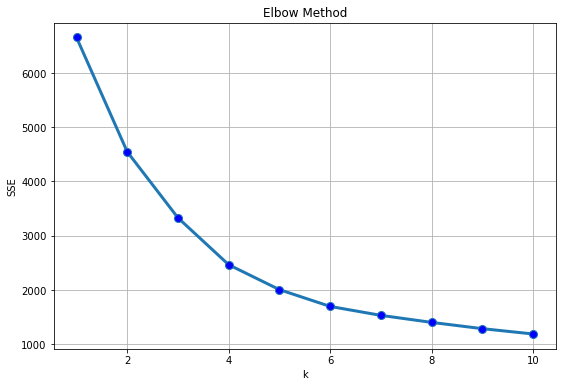

In [37]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(range(1, 11), sse, linewidth = 3, marker = 'o', markerfacecolor = 'blue', markersize = 8)
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show;

### Silhouette Method

In [38]:
# silhouette method to confirm number of clusters
sil = []
kmax = 10

for k in range(2, kmax + 1):
  kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_normal)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_normal, labels, metric = 'euclidean'))

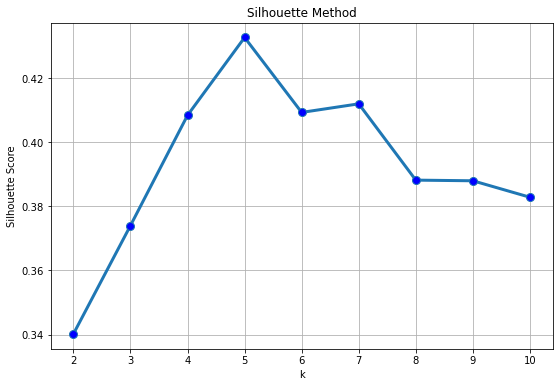

In [39]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(range(2, 11), sil, linewidth = 3, marker = 'o', markerfacecolor = 'blue', markersize = 8)
plt.title('Silhouette Method')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show;

### Training

In [40]:
kmeans= KMeans(n_clusters = 5, random_state = 42) 
kmeans.fit(df_normal)

cluster_labels = kmeans.labels_
df_rfm = data.assign(Cluster = cluster_labels)
df_rfm.head()

,Recency,Frequency,Monetary,Cluster
Buyer ID,,,,
Andrews,407,2,25.98,1
Bell191,201,2,41.98,1
Boggs41,74,2,66.97,2
Carter3,363,3,80.94,1
Danna23,609,1,186.99,3


### Results

In [41]:
# Group data by cluster
cluster = df_rfm.groupby(['Cluster'])
cluster.agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         429.8       1.0     18.2   923
1         429.2       2.5     46.8   439
2          56.1       1.3     41.2   251
3         311.4       1.1    103.1   473
4         264.6       6.3    178.1   132

# Conclusion

## Snake Plot

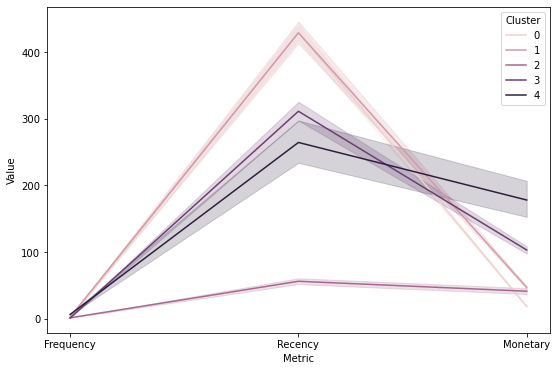

In [42]:
plt.figure(figsize = (9,6))
df_melt = pd.melt(df_rfm.reset_index(), id_vars = ['Buyer ID', 'Cluster'], value_vars = ['Frequency', 'Recency', 'Monetary'], 
                    var_name = 'Metric', value_name = 'Value')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data = df_melt, x = 'Metric', y = 'Value', hue = 'Cluster');

* Cluster 4 is reminiscent of the 'Best Customers' segment from the RFM table as they purchased relatively recently (R = 3), frequent buyers (F = 4) and spend the most (M = 4). They should be promoted new products and give loyalty promotions.
* Cluster 3 are the 'Almost Lost' segment who have not purchased in a while (R = 2), infrequent (F = 1) but spend a lot (M = 4). Aggressive price incentives should be used to try lure them back.
* Cluster 2 features recent customers (R = 4) who are not frequent (F = 1/ 2) and spend moderately (M = 2). Price incentives strategies should be used to grow customer loyalty.
* Cluster 1 and 0 are passerby customers who made their last purchase long ago (R = 1), purchased very few (F = 1 - 3) and spent little (M = 1/ 2)

## Relative Importance

In [43]:
cluster_avg = df_rfm.groupby(['Cluster']).mean() 
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,429.823402,1.007584,18.246544
1,429.248292,2.466970,46.830068
2,56.115538,1.270916,41.181594
3,311.393235,1.078224,103.083066
4,264.553030,6.272727,178.141818


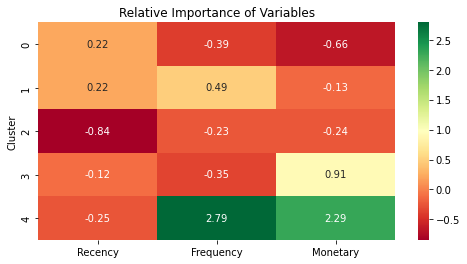

In [44]:
pop_avg = data.mean()
rel_importance = cluster_avg / pop_avg - 1

plt.figure(figsize=(8, 4))
plt.title('Relative Importance of Variables')
sns.heatmap(rel_importance, annot = True, fmt='.2f', cmap = 'RdYlGn')
plt.show()